In [ ]:
!pip install fastai
!pip install timm

In [30]:
from fastai.vision.all import *
import timm

In [31]:
path = Path('./scene_classification_clean/data/')

In [32]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(150)],
        batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75))

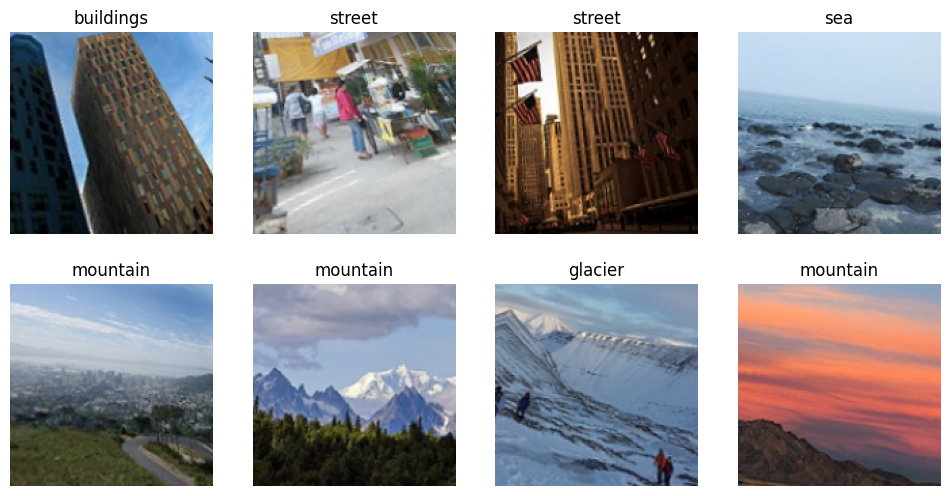

In [33]:
loaders = block.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2)

In [ ]:

timm.list_models('convnext*')

In [34]:
learn = vision_learner(loaders, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0008317637839354575)

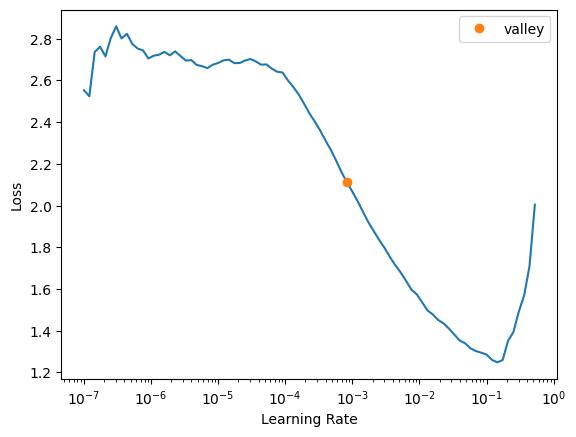

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.398247,0.238486,0.931517,00:12


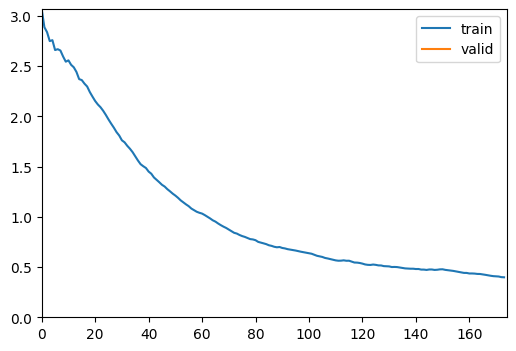

epoch,train_loss,valid_loss,accuracy,time
0,0.279490,0.199708,0.935461,00:16
1,0.245300,0.196639,0.935819,00:16
2,0.225461,0.181244,0.940839,00:16
3,0.205671,0.166005,0.944066,00:16
4,0.193317,0.173236,0.940839,00:16
5,0.159918,0.169454,0.945859,00:17
6,0.159010,0.161164,0.943707,00:17
7,0.136617,0.159572,0.949444,00:16
8,0.127150,0.169944,0.941915,00:17
9,0.134663,0.161035,0.944783,00:16


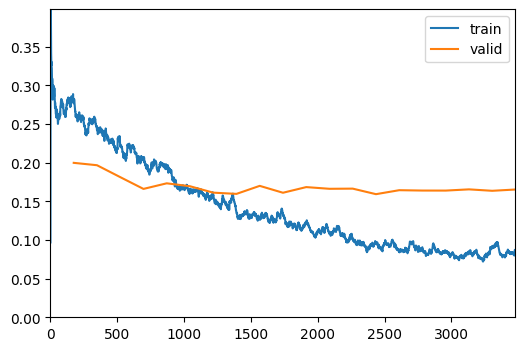

In [36]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

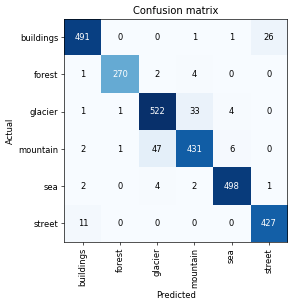

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

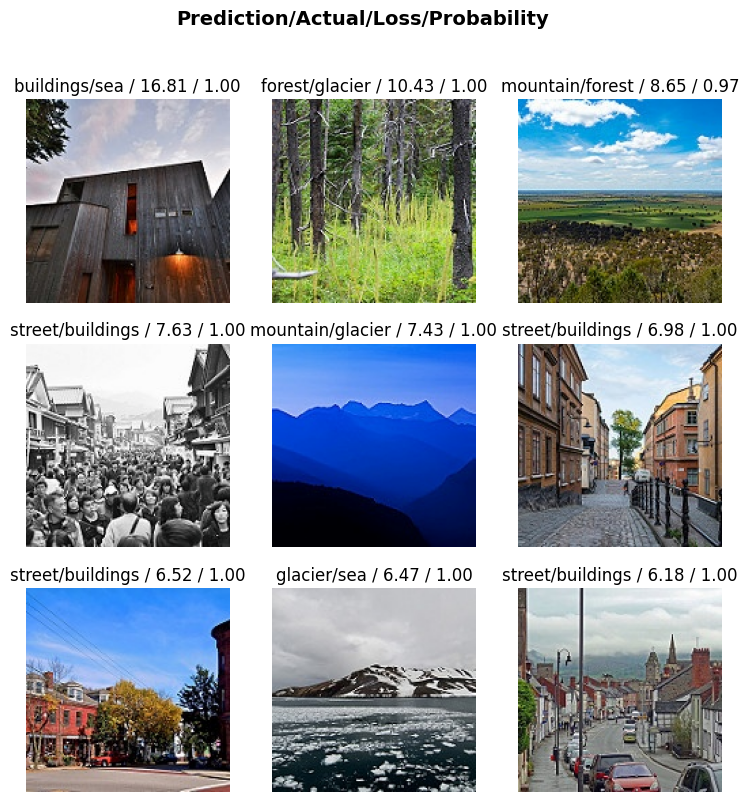

In [39]:
interp.plot_top_losses(9)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn, height=256)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
test_dl = learn.dls.test_dl(get_image_files('scene_classification/data/test_set/'))
learn.get_preds(dl=test_dl)

In [ ]:
preds = learn.get_preds(dl=test_dl)
for index,item in enumerate(preds[0]):
    prediction = learn.dls.categorize.decode(np.argmax(item)).upper()
    confidence = max(item)
    percent = float(confidence)
    print(f"{prediction}   {percent*100:.2f}% confidence.   Image = {learn.dls.items[index].name}")